In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [9]:
df = pd.read_csv('heart_failure.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,x,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [10]:
df.replace({'ExerciseAngina': {'Y': 1, 'N': 0}}, inplace=True)
df.replace({'Sex': {'M': 1, 'F': 0}}, inplace=True)
df.replace({'ChestPainType': {'ASY': 0, 'NAP': 1, 'ATA': 2, 'TA': 3}}, inplace=True)
df.replace({'RestingECG': {'Normal': 0, 'ST': 1, 'LVH': 2}}, inplace=True)
df.replace({'ST_Slope': {'Down': 0, 'Flat': 1, 'Up': 2}}, inplace=True)
df.head()

,Age,Sex,ChestPainType,RestingBP,x,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,2,140,289,0,0,172,0,0.0,2,0
1,49,0,1,160,180,0,0,156,0,1.0,1,1
2,37,1,2,130,283,0,1,98,0,0.0,2,0
3,48,0,0,138,214,0,0,108,1,1.5,1,1
4,54,1,1,150,195,0,0,122,0,0.0,2,0


In [11]:
# Feature name and class name
feature_names = ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'x', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope']
df.columns = feature_names + ['HeartDisease'] # Feature를 더 간략한 이름으로 변경
class_names = ['Yes', 'No'] # 0: 'Begnign', 1: 'Malignant'
# df['Class'] = df['Class'].map({'Benign': 0, 'Malignant': 1}) # Benign : 0, Malignant: 1로 변경

# Splitting the dataset
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

### 일반 Decision tree

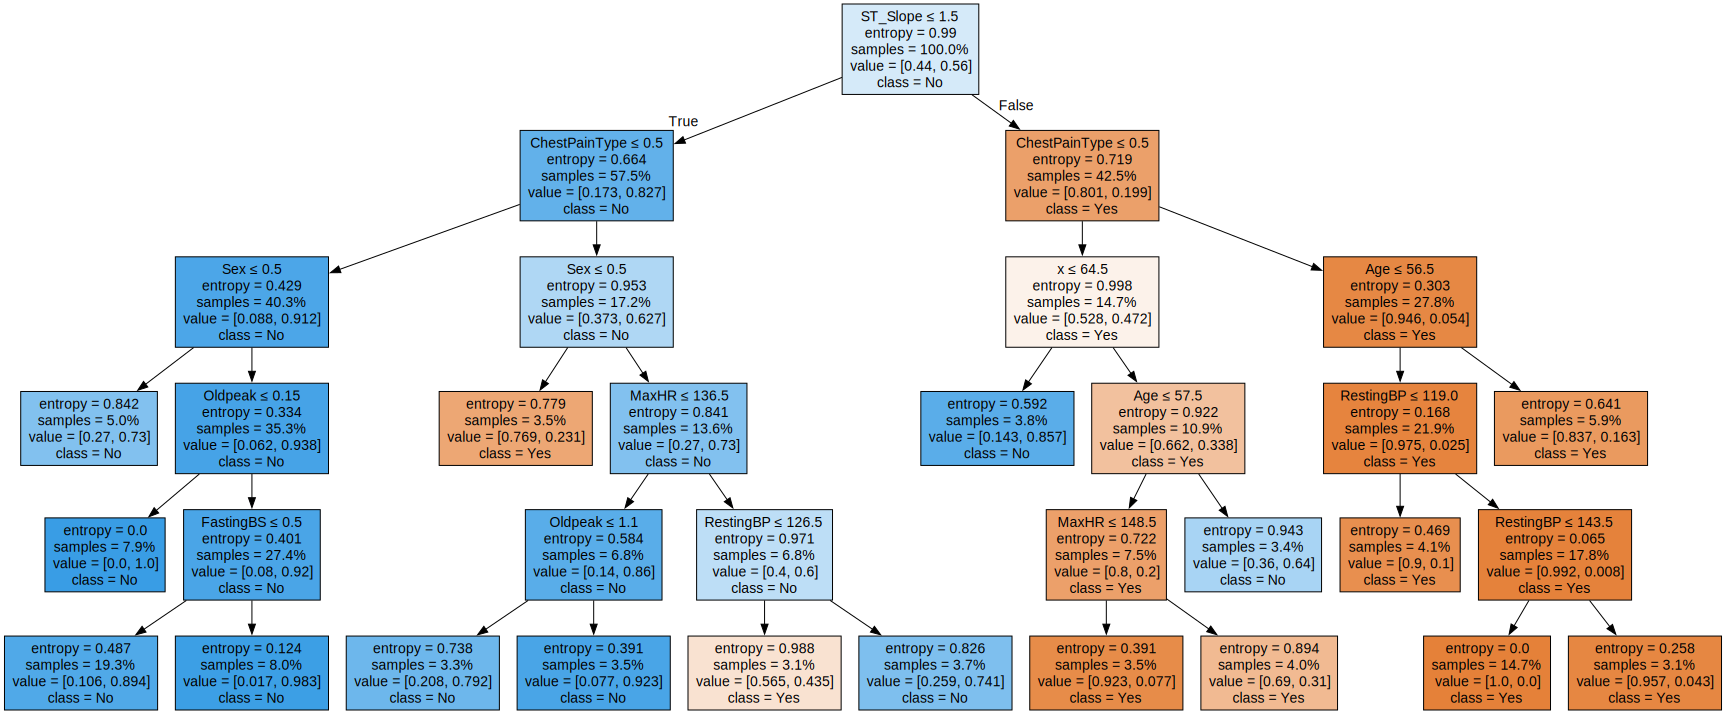

In [14]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

# Decision tree fitting
dt = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=0.03, max_depth=5, random_state=12)
dt.fit(X_train, y_train)

# Visualization
dot_data = export_graphviz(dt, out_file=None, 
                      feature_names=feature_names,
                      class_names=class_names,  
                      filled=True, rounded=False,
                      proportion=True,
                      special_characters=True)  
visualize_dt = graphviz.Source(dot_data)  
visualize_dt

### Color DT

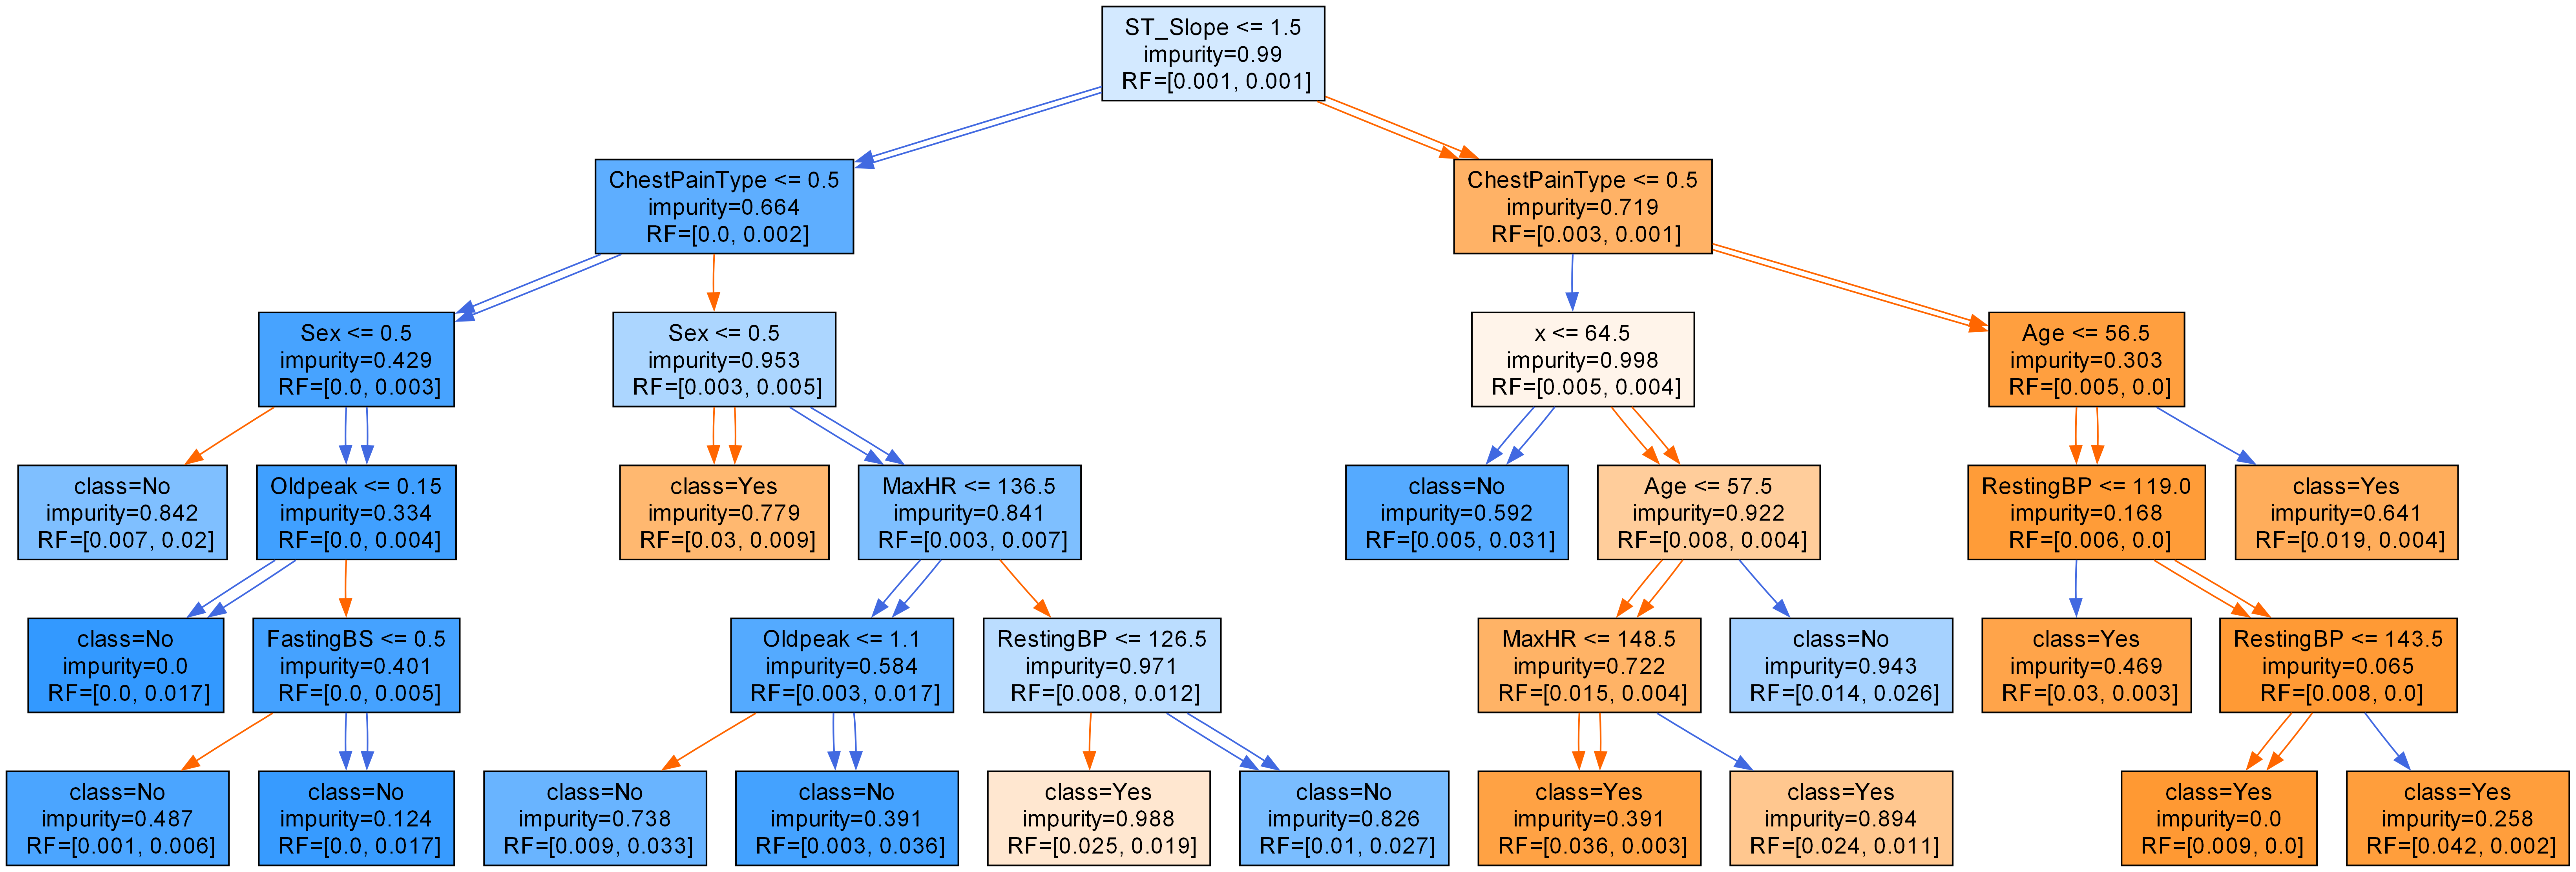

Color Decision Tree saved as 'color_dt.png'


In [15]:
from colorDT_sklearn import colorDT # colorDT_sklearn.py

color_dt = colorDT(model=dt, feature_names=feature_names, class_names=class_names)
color_dt.display_color_tree()
color_dt.save_color_tree(output_file='color_dt')

In [9]:
color_dt.display_rules(X_train, y_train)


Rules:
Rule (Type 2)
Original Rule:
IF ST_Slope <= 1.5 and ChestPainType <= 0.5 and Sex <= 0.5 THEN class = No (RF: 0.73)
Compact Rule (Method 1 - Full path IR Removal):
IF ST_Slope <= 1.5 and ChestPainType <= 0.5 THEN class = No (RF: 0.912)
Compact Rule (Method 2 - Max RF node-based IR Removal):
IF ST_Slope <= 1.5 and ChestPainType <= 0.5 and Sex <= 0.5 THEN class = No (RF: 0.73)

Rule (Type 1)
Original Rule:
IF ST_Slope <= 1.5 and ChestPainType <= 0.5 and Sex > 0.5 and Oldpeak <= 0.15000000223517418 THEN class = No (RF: 1.0)
Compact Rule:
IF ST_Slope <= 1.5 and ChestPainType <= 0.5 and Sex > 0.5 and Oldpeak <= 0.15000000223517418 THEN class = No (RF: 1.0)

Rule (Type 2)
Original Rule:
IF ST_Slope <= 1.5 and ChestPainType <= 0.5 and Sex > 0.5 and Oldpeak > 0.15000000223517418 and FastingBS <= 0.5 THEN class = No (RF: 0.894)
Compact Rule (Method 1 - Full path IR Removal):
IF ST_Slope <= 1.5 and ChestPainType <= 0.5 and Sex > 0.5 THEN class = No (RF: 0.938)
Compact Rule (Method 2 - Max

In [25]:
test_score = accuracy(y_test, DT_pred)

print(f'Test Score: {test_score}')

Test Score: 0.9456521739130435


### Type별 RF table

In [20]:
epsilon=0.07
color_dt.type_rf_table(epsilon)

,Rule Count,RF Diff < Epsilon,Ratio
Rule Type,,,
Type 1-n,2,2,1.00
Type 1-y,8,4,0.50
Type 2-m1,9,3,0.33
Type 2-m2-n,8,8,1.00
Type 2-m2-y,1,1,1.00


### Type별 RF table의 평균 계산

In [17]:
# Define the parameters
epsilon = 0.07
num_iterations = 30 # 최소 10번 이상

summary_tables = []
for _ in range(num_iterations):
    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2)
    dt = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=0.03)
    dt.fit(X_train, y_train)
    
    color_dt = colorDT(model=dt, feature_names=feature_names, class_names=class_names)
    color_dt.classify_rules(X_train, y_train)

    type_rf_table = color_dt.type_rf_table(epsilon)
    summary_tables.append(type_rf_table)

combined_summary_table = pd.concat(summary_tables)
averaged_summary_table = combined_summary_table.groupby(combined_summary_table.index).mean()
averaged_summary_table.round(3)

,Rule Count,RF Diff < Epsilon,Ratio
Rule Type,,,
Type 1-n,2.000,2.000,1.000
Type 1-y,7.867,4.800,0.605
Type 2-m1,10.833,3.167,0.285
Type 2-m2-n,7.933,7.933,1.000
Type 2-m2-y,2.900,1.933,0.673


### Color DT: Homogenous subtree pruning

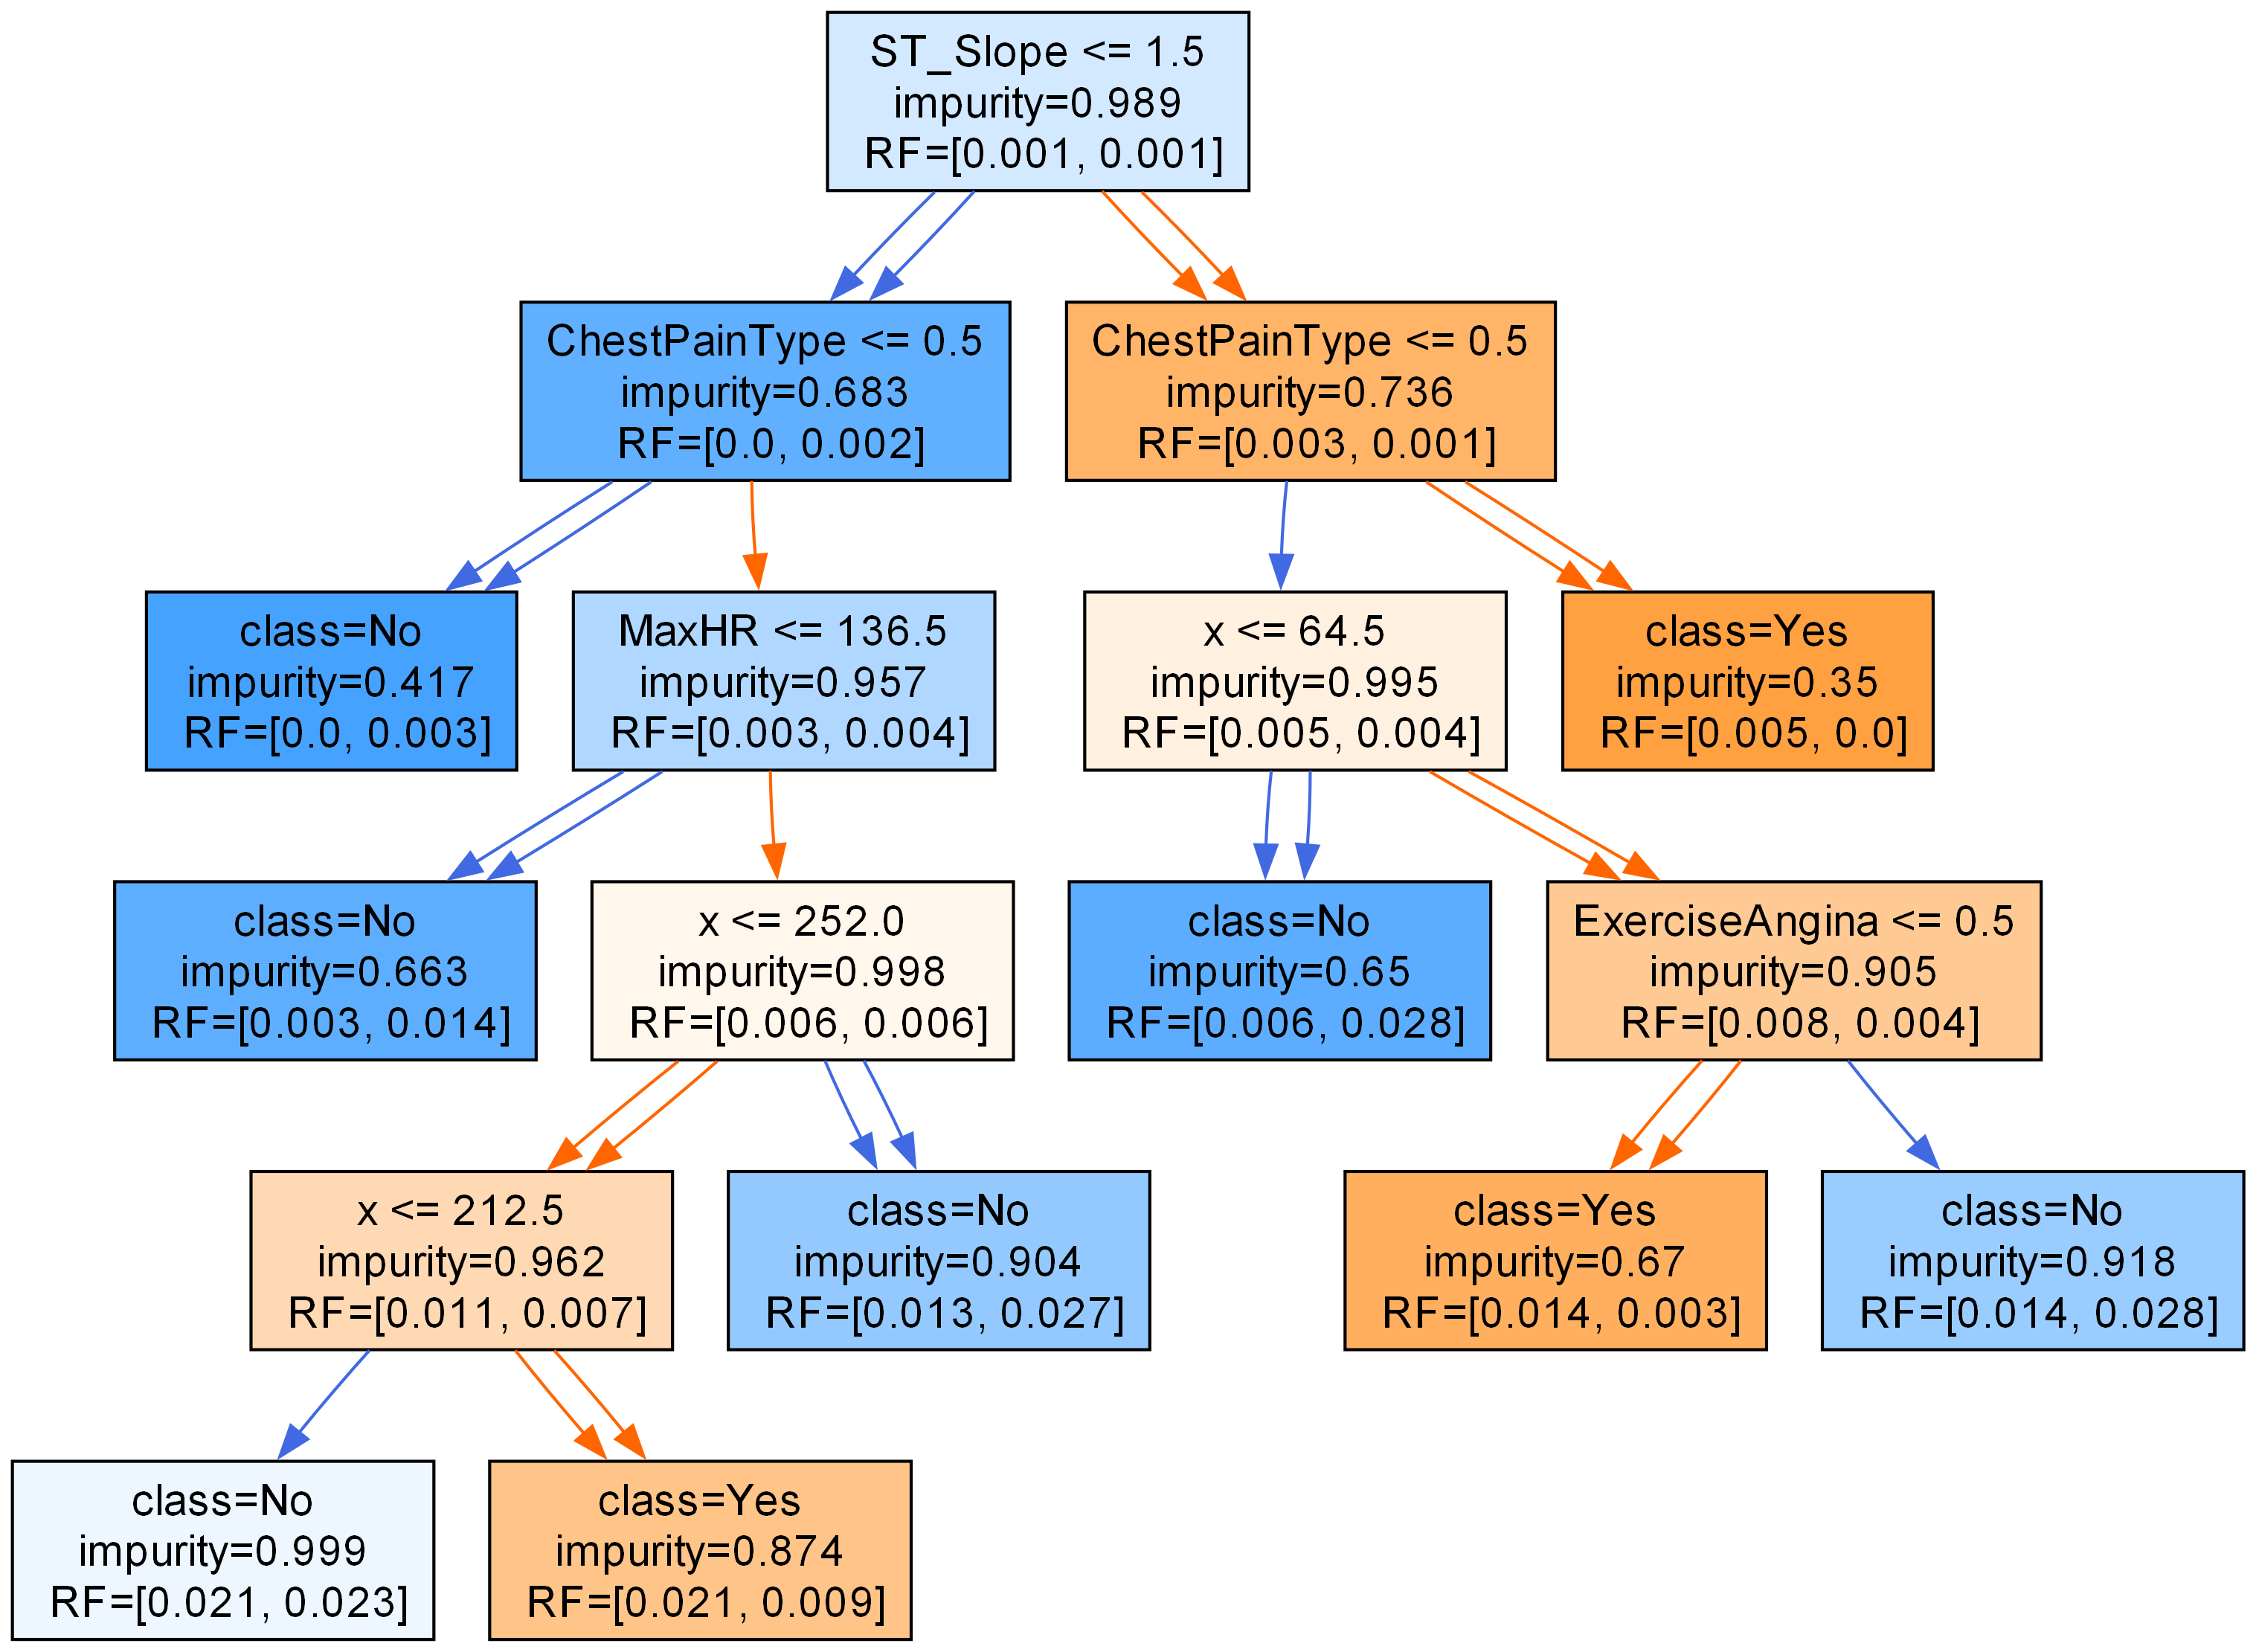

Pruned Color Decision Tree saved as 'color_dt_pruned.png'


In [12]:
color_dt = colorDT(model=dt, feature_names=feature_names, class_names=class_names)
color_dt.display_color_tree_pruned()
color_dt.save_color_tree_pruned(output_file='color_dt_pruned')

In [13]:
color_dt.display_rules(X_train, y_train)


Rules:
Rule (Type 1)
Original Rule:
IF ST_Slope <= 1.5 and ChestPainType <= 0.5 THEN class = No (RF: 0.916)
Compact Rule:
IF ST_Slope <= 1.5 and ChestPainType <= 0.5 THEN class = No (RF: 0.916)

Rule (Type 1)
Original Rule:
IF ST_Slope <= 1.5 and ChestPainType > 0.5 and MaxHR <= 136.5 THEN class = No (RF: 0.828)
Compact Rule:
IF ST_Slope <= 1.5 and MaxHR <= 136.5 THEN class = No (RF: 0.91)

Rule (Type 2)
Original Rule:
IF ST_Slope <= 1.5 and ChestPainType > 0.5 and MaxHR > 136.5 and x <= 252.0 and x <= 212.5 THEN class = No (RF: 0.522)
Compact Rule (Method 1 - Full path IR Removal):
IF ST_Slope <= 1.5 and x <= 212.5 THEN class = No (RF: 0.863)
Compact Rule (Method 2 - Max RF node-based IR Removal):
IF ST_Slope <= 1.5 and ChestPainType > 0.5 and MaxHR > 136.5 and x <= 252.0 and x <= 212.5 THEN class = No (RF: 0.522)

Rule (Type 1)
Original Rule:
IF ST_Slope <= 1.5 and ChestPainType > 0.5 and MaxHR > 136.5 and x <= 252.0 and x > 212.5 THEN class = Yes (RF: 0.706)
Compact Rule:
IF ChestP